### Use Case ###

Build a Machine Learning Algorithm that can able to predict the target variable #7 with given two set of files. Namely n.csv, o.csv. Both data are **weakly** aggregated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
#import modules
import sys
import os
import importlib
import types

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/modules")

    
def walk_reload(module: types.ModuleType) -> None:
    if hasattr(module, "__all__"):
        for submodule_name in module.__all__:
            walk_reload(getattr(module, submodule_name))
    importlib.reload(module)

In [3]:
#import custom modules
#whenever we make changes in the modules
#need to run this file again
import adf 

#reload
walk_reload(adf)

In [4]:
def read_dataset(path):
    df = pd.read_csv(path, sep=",")
    return df

In [5]:
ndf_path = '../data/raw/n.csv'
odf_path = '../data/raw/o.csv'

ndf, odf = read_dataset(ndf_path), read_dataset(odf_path)
print("First Dataset Path:{}".format(ndf.shape))
print("Second Dataset Path:{}".format(odf.shape))

First Dataset Path:(525, 12)
Second Dataset Path:(525, 12)


In [6]:
#give summary and info about the data
def give_info(df):
    return df.info()

In [7]:
##publish_date column dtype is an object
##convert object dtype -> datetime[ns]
def todatetime(df, column):
    df[column] = pd.to_datetime(df[column])
    return df

ndf = todatetime(ndf, 'pub_date')
odf = todatetime(odf, 'pub_date')

In [8]:
give_info(ndf)
give_info(odf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 12 columns):
Unnamed: 0      525 non-null int64
Unnamed: 0.1    525 non-null int64
pub_date        525 non-null datetime64[ns]
actual          525 non-null int64
forecast        525 non-null int64
previous        525 non-null int64
rolling_std     525 non-null float64
z-score         525 non-null float64
1               525 non-null float64
5               525 non-null float64
6               525 non-null int64
7               525 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(6)
memory usage: 49.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 12 columns):
Unnamed: 0      525 non-null int64
Unnamed: 0.1    525 non-null int64
pub_date        525 non-null datetime64[ns]
actual          525 non-null float64
forecast        525 non-null float64
previous        525 non-null float64
rolling_std     525 non-null float64
z-score         525

In [9]:
def get_history_date(df, column):
    start=df[column].min().strftime('%Y-%m-%d')
    end=df[column].max().strftime('%Y-%m-%d')
    
    return start, end

ndf_historystart, ndf_historyend = get_history_date(ndf, 'pub_date')
odf_historystart, odf_historyend = get_history_date(odf, 'pub_date')

In [10]:
print("N FileSet History Data, Start={}, End= {}".format(ndf_historystart, ndf_historyend))
print("O FileSet History Date, Start={}, End= {}".format(odf_historystart, odf_historyend))

N FileSet History Data, Start=2008-03-27, End= 2018-05-10
O FileSet History Date, Start=2008-03-26, End= 2018-05-09


In [11]:
##the target variable is in range -1 to 1. To test the hypothesis
##scale the input datapoints
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def minmaxscaler(df, date, target):
    #remove the target variable and date variable and unnamed columns
    #which are generally index
    cols_to_remove = [date, target]
    needed_columns = []
    for cols in df.columns.tolist():
        if ('Unnamed: 0' in cols) or (cols in cols_to_remove):
            pass
        else:
            needed_columns.append(cols)
    
    print(needed_columns) #-->check
    needed_df = df[needed_columns]
    needed_df = scaler.fit_transform(needed_df)
    
    needed_df = pd.DataFrame(needed_df, columns=needed_columns)
    needed_df[date] = df[date]
    needed_df[target] = df[target]
    
    return needed_df

In [12]:
scaled_ndf = minmaxscaler(ndf, 'pub_date', '7')
scaled_odf = minmaxscaler(odf, 'pub_date', '7')

['actual', 'forecast', 'previous', 'rolling_std', 'z-score', '1', '5', '6']
['actual', 'forecast', 'previous', 'rolling_std', 'z-score', '1', '5', '6']


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
##plot the actual, forecast and volume to test the 
##hypothesis that Bigger the difference between actual vs forecast
##the bigger impact in #7
def compare_plot_trend(df):
    plt.figure(figsize=(20, 10))
    date, actual, forecast, target = df['pub_date'], df['actual'], df['forecast'], df['7'] 
    plt.plot(date, actual, color='blue', label='Actual')
    plt.plot(date, forecast, color='orange', label='Forecast')
    plt.plot(date, target, color='red', label='Target')
    plt.xlabel('Date')
    plt.ylabel('Values')
    
    plt.legend()
    
    plt.show()

def plot_trend(df, col):
    plt.figure(figsize=(20, 10))
    date = df['pub_date']
    plt.plot(date, df[col])
    
    #rolling mean by 12 months
    rolling_mean = df[col].rolling(window=12).mean()
    plt.plot(date, rolling_mean, color='red', label='Rolling Mean')
    
    rolling_std = df[col].rolling(window=12).std()
    plt.plot(date, rolling_std, color='black', label='Rolling Std')
    
    plt.xlabel('Date')
    plt.ylabel("Std")
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


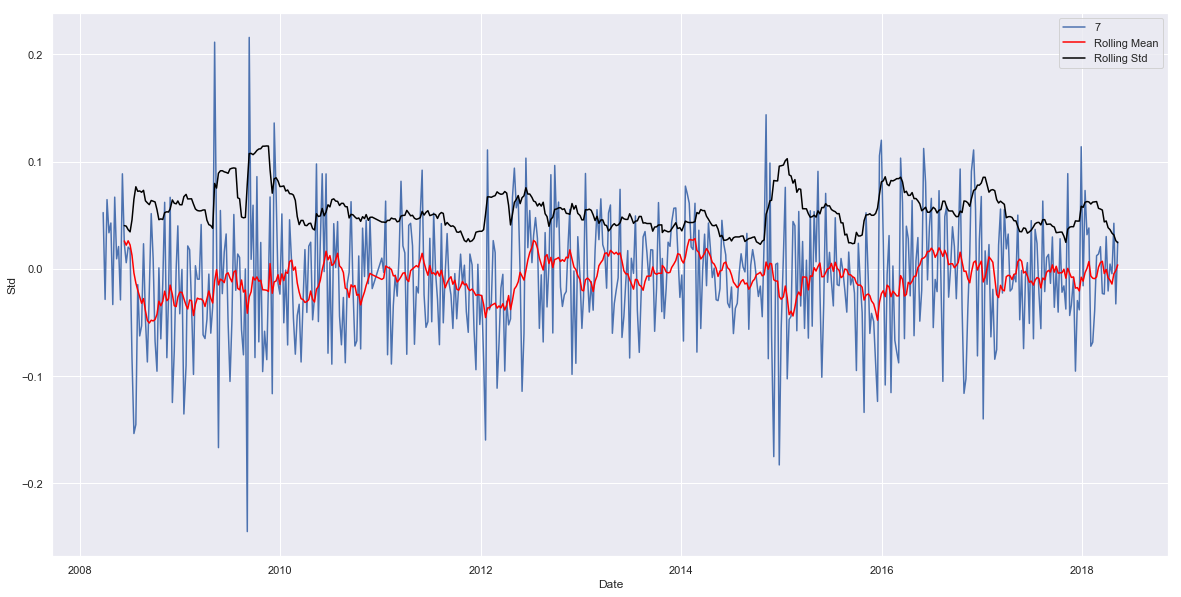

In [14]:
plot_trend(ndf, '7')

### Stationary Tests ###

To determine if a time series is stationary or not, we will use the ADF test which is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

    **Null Hypothesis** states there is the presence of a unit root.
    **Alternate Hypothesis** states there is no unit root. In other words, Stationarity exists.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

**Note**

If there is an obvious trend in either the mean or variance over the N sections, then your series is not stationary.  If not, then is may well be stationary.

In [15]:
stest = adf.StationarityTests()
result = stest.ADF_Stationarity_Test('None', ndf['7'])
result

{'Item': 'None',
 'ADF Test Statistics': -23.450137332601447,
 'P-Value': 0.0,
 'Lags Used': 0,
 'Observed Used': 524,
 'isStationary': True,
 'critical_values': {'1%': -3.4428912664970523,
  '5%': -2.867071538125014,
  '10%': -2.5697161081813413}}

### check seasonal patterns ###

One way to think about the seasonal components to the time series of your data is to remove the trend from a time series, so that you can more easily investigate seasonality. To remove the trend, subtract the trend you computed above (rolling mean) from the original signal. This, however, will be dependent on how many data points you averaged over.

In [16]:
def check_seasonal_patterns(df, column):
    plt.figure(figsize=(20, 10))
    date = df['pub_date']
    differencing = df[column].diff()
    
    #plot
    plt.plot(date, differencing, label='Checking Seasonality')
    
    plt.xlabel('Date')
    plt.ylabel('First Order Differencing')
    plt.legend()
    plt.show()

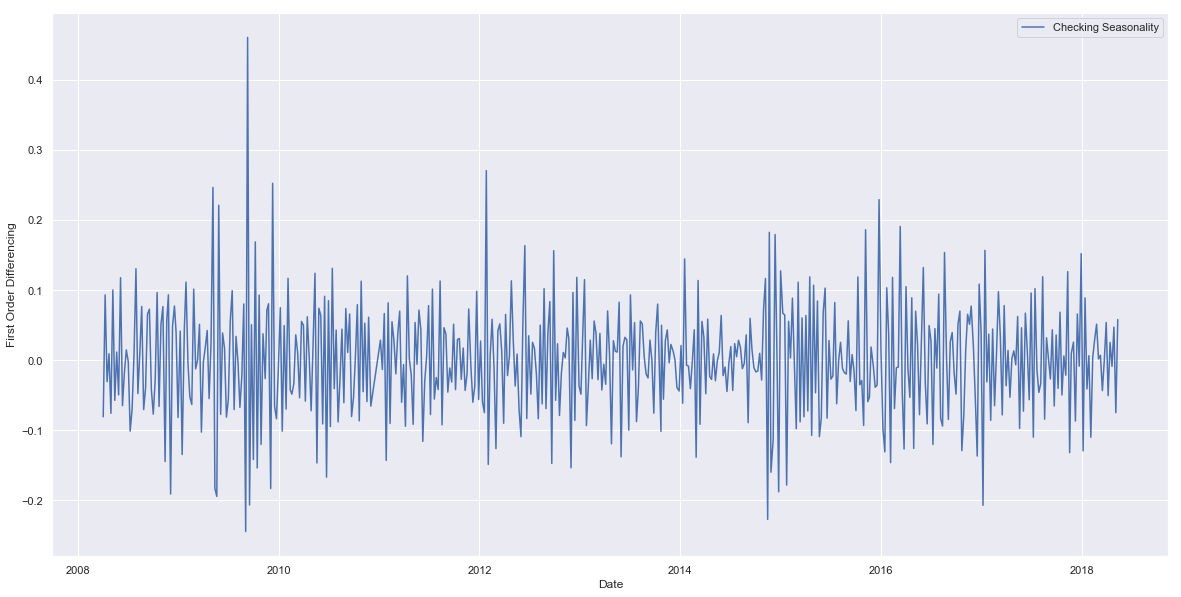

In [17]:
check_seasonal_patterns(ndf, '7')

### ACF ###

If the Lag points are above the statistical significance value then it is not happening by chance, there is some statistical approach backening up(basically seasonal components). It explains how many previous value is affecting the lag value

In [18]:
def acf_plot(df, column):
    plt.figure(figsize=(20, 10))
    series = df[column]
    significantvalue = 2/np.sqrt(len(series))
    print("Significant Value:{}".format(significantvalue))
    pd.plotting.autocorrelation_plot(df[column]);
    plt.show()

Significant Value:0.08728715609439695


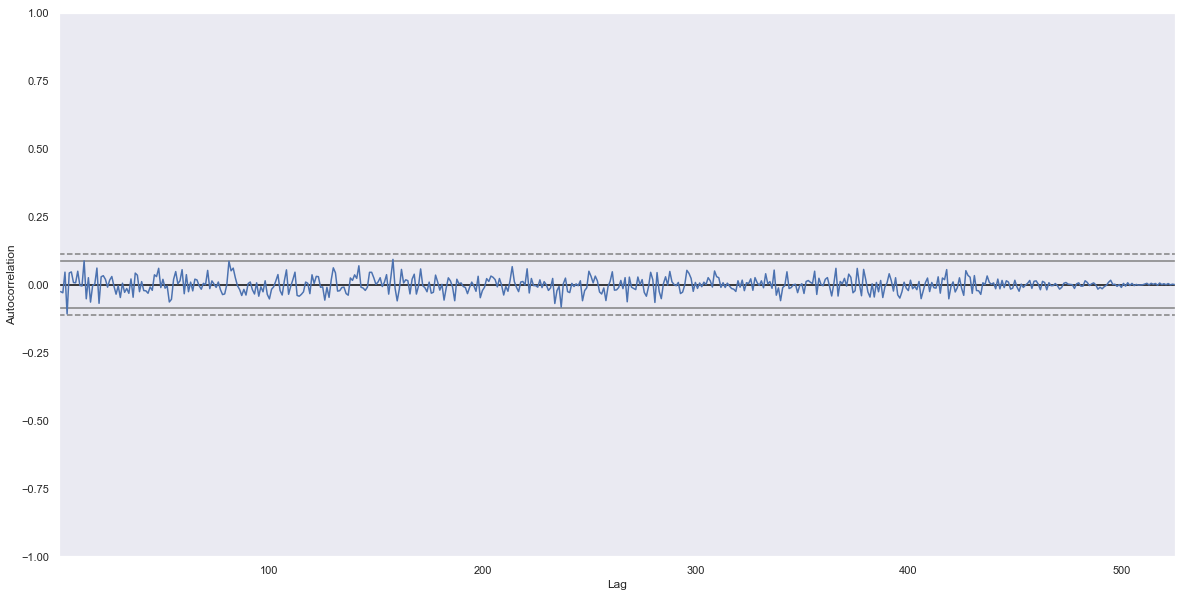

In [19]:
acf_plot(ndf, '7')

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def decomposition(df, column):
    data = pd.DataFrame()
    result = seasonal_decompose(df[column], model='additive', freq = 14)
    data["trend"] = result.trend
    data["seasonal"] = result.seasonal
    data["residuals"] = result.resid
    data["observed"] = result.observed
    
    return data

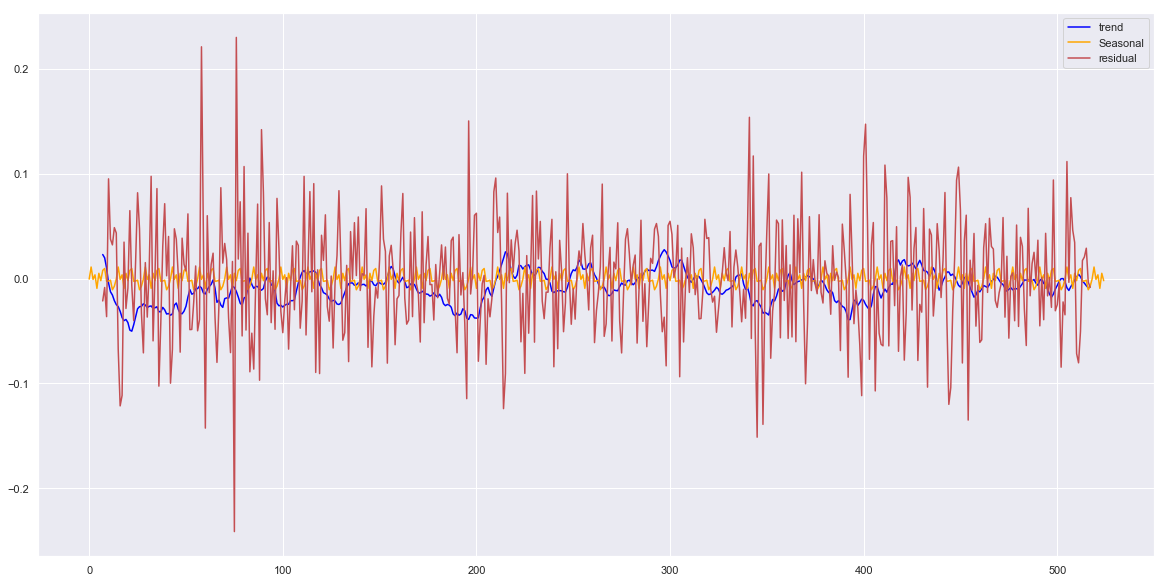

In [21]:
d = decomposition(ndf, '7')

plt.figure(figsize=(20, 10))
plt.plot(d['trend'], color='blue', label='trend')
plt.plot(d['seasonal'], color='orange', label='Seasonal')
plt.plot(d['residuals'], color='r', label='residual')
#plt.plot(d['observed'], color='brown', label='observed')
plt.legend()

plt.show()

In [22]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 4 columns):
trend        511 non-null float64
seasonal     525 non-null float64
residuals    511 non-null float64
observed     525 non-null float64
dtypes: float64(4)
memory usage: 16.5 KB


In [23]:
##so we have 10 years of data from 2008 - 2018
##will check residual errors and see if the distribution
##varies for each year of the data

def split_data_by_year_wise(df, residualdf,datecolumn):
    plt.figure(figsize=(20, 10))
    df['year'] = pd.DatetimeIndex(df[datecolumn]).year
    year = df['year'].value_counts().keys()
    
    #concat residual data too
    combined_df = pd.concat([df, residualdf], axis=1)
    #print(combined_df.head())
       
    for y in year:
        year_residuals = combined_df[combined_df['year'] == y]['residuals']
        year_residuals.plot(kind='kde', label=str(y))
    
    plt.title("Residual comparision from 2008 - 2018")
    plt.legend()
    plt.show()

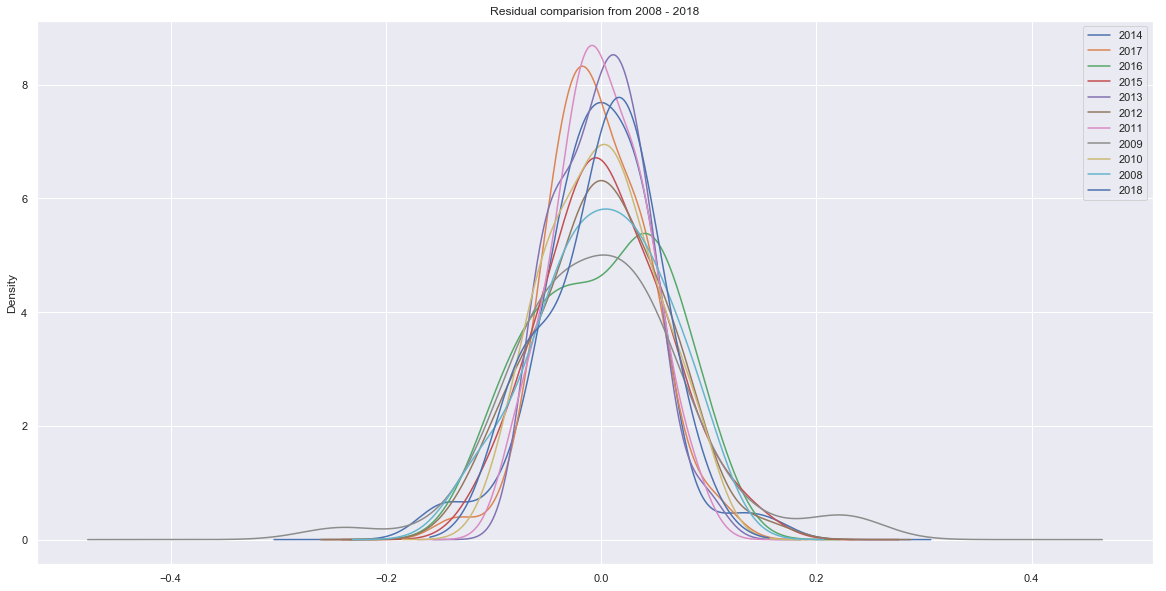

In [24]:
split_data_by_year_wise(ndf, d,'pub_date')

The overall residuals vary greatly by year comparision. Let's build a General Forecasting Model and see how the model is performing in train and evaluation dataset.

### Dataset Module ###

In [68]:
class Dataset:
    
    #initial class objects
    def __init__(self, dataset, datecolumn, forecastcolumn):
        self.df = dataset.copy()
        self.date = datecolumn
        self.forecastcolumn = forecastcolumn
        
    #normal split
    def normal_split(self):
        date_series = self.df[self.date]
        #sort the dataset by index
        self.df.index = date_series
        self.df = self.df.sort_index()
        
        #take 70% data for train, 30% for evaluation dataset
        train_size = int(self.df.shape[0] * 0.77)
        #split the dataset
        train_split, eval_split = self.df.iloc[0:train_size], self.df.iloc[train_size:]
        #train values
        train_split, eval_split = train_split[[self.forecastcolumn]], eval_split[[self.forecastcolumn]]
        
        return train_split, eval_split
    
    #split by year wise
    def split_by_year_wise(self):
        date_series = self.df[self.date]
        
        #sort by dataset by index
        self.df.index = date_series
        self.df = self.df.sort_index()
        
        #get year data
        year = self.df['year'].value_counts().keys().values.tolist()
        year.sort()
        train_set = year[:-2]
        test_set = year[-2:] #get last 2 years
        
        train_split = self.df[self.df['year'].isin(train_set)][[self.forecastcolumn]]
        test_split = self.df[self.df['year'].isin(test_set)][[self.forecastcolumn]]
        
        return train_split, test_split

In [69]:
#ndf_trainsplit, ndf_evalsplit = Dataset(ndf, 'pub_date', '7').normal_split()
ndf_trainsplit, ndf_evalsplit = Dataset(ndf, 'pub_date', '7').split_by_year_wise()

### plotting the model Forecasting values ###

In [70]:
#function to plot the trend, actual, preds
def plot_trend(historydf, forcast_dates ,actual, forecast_values, error_rate, filename):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 10))
    
    plt.plot(historydf.index, historydf['7'], color='b', label='History Values')
    plt.plot(forcast_dates, actual, color='orange', label='actual Values')
    plt.plot(forcast_dates, forecast_values, '--',color='red', label='forecasted values')
    
    plt.legend()
    plt.title("error_rate:{}".format(error_rate))
    plt.savefig(filename)
    plt.show()
    plt.close() #close the figure

In [71]:
print(len(ndf_trainsplit), len(ndf_evalsplit))

454 71


### Exponential Smoothing ###

In [77]:
##class builder for Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class Smoothing():
    def __init__(self, dataframe, forecasting_col, traindataset, testdataset):
        self.dataset = dataframe
        self.forecastingcol = forecasting_col
        self.series = self.dataset[self.forecastingcol]
        self.traindata = traindataset
        self.testdata = testdataset
        self.predictions=None
        self.bestScore = float('inf')
        self.lag = None
    
    def grid_search(self):
        range_ = range(3, 30)
        for lag in range_:
            mse, preds = self.evaluate_model(lag)
            if mse < self.bestScore:
                self.bestScore = mse
                self.lag = lag
                self.predictions = preds
            
            #check model training
            if lag % 7 == 0 and lag != 0:
                print("Completed Exponential Smoothing for Params:{}".format(lag))
        
    def evaluate_model(self, lag):
        #train_size = int(len(self.series) * 0.77)
        #train, test = self.dataset.iloc[0:train_size], self.dataset.iloc[train_size:]
        
        
        train, test = self.traindata[self.forecastingcol].values.tolist(), self.testdata[self.forecastingcol].values.tolist()
        
        fit = ExponentialSmoothing(train, seasonal_periods=lag,
                                  trend='add', seasonal='add', damped=True).fit()
        
        preds = fit.forecast(len(test))
        self.predictions = preds
        
        #calculate out of sample error
        predictions = [x for x in preds]
        error = mean_squared_error(test, preds)
        
        #error = np.mean(np.abs((np.array(test) - np.array(predictions)) / test)) * 100
        
        return error, predictions

In [85]:
sm = Smoothing(ndf, '7', ndf_trainsplit, ndf_evalsplit)
sm.grid_search()

Completed Exponential Smoothing for Params:7
Completed Exponential Smoothing for Params:14
Completed Exponential Smoothing for Params:21
Completed Exponential Smoothing for Params:28


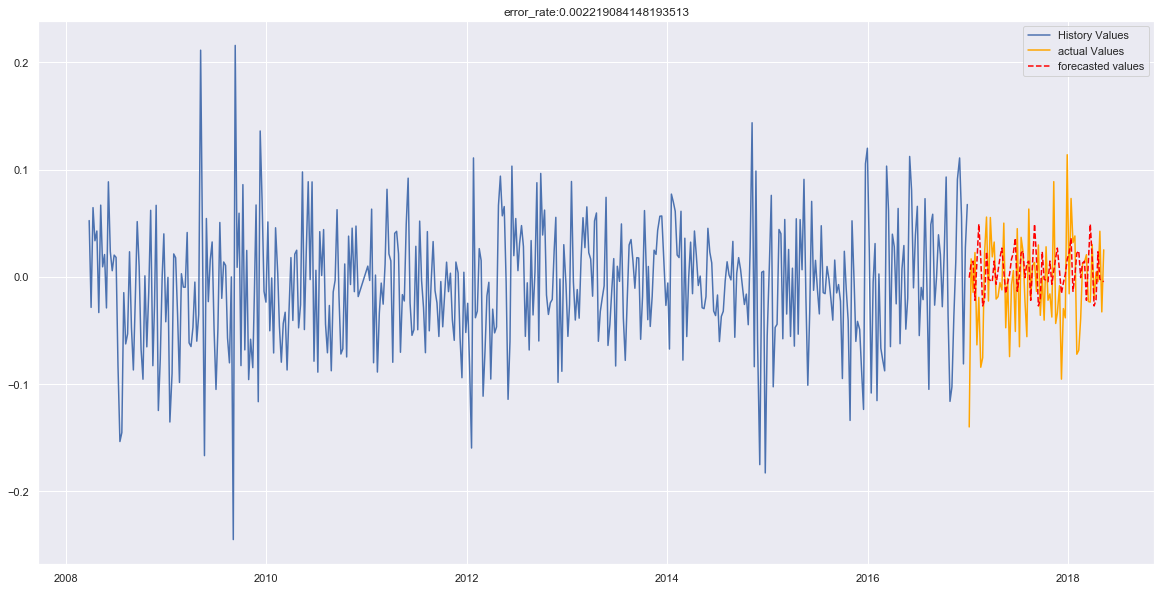

In [86]:
plot_trend(sm.traindata, sm.testdata.index,
           sm.testdata['7'], sm.predictions,sm.bestScore,
           'exponential_smoothing_damped_2.png') #trained with 2008 - 2016, tested on 2017-2018

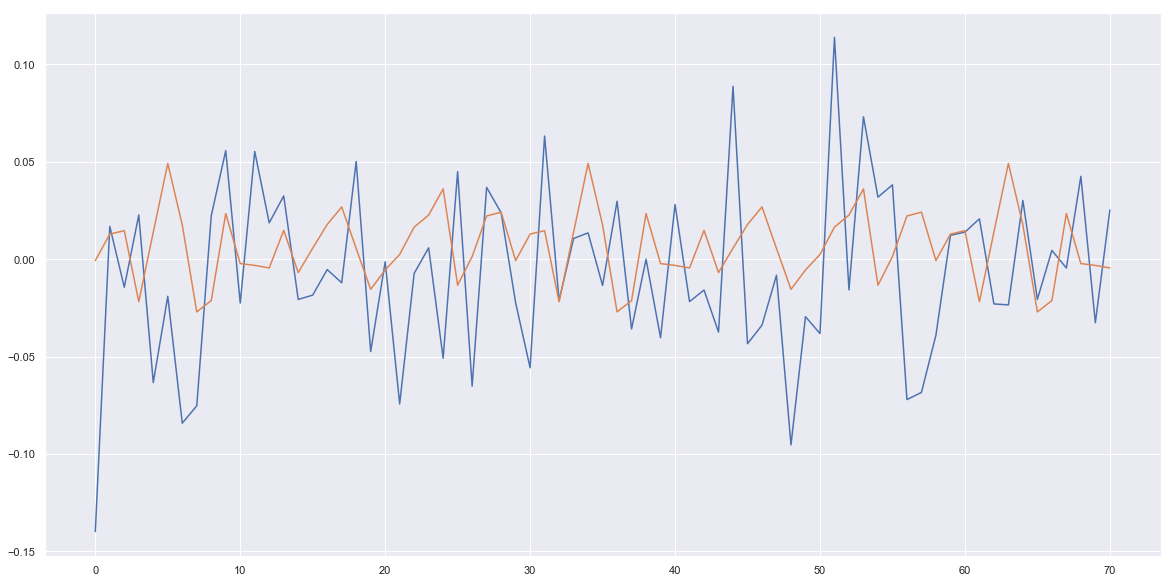

In [90]:
plt.figure(figsize=(20, 10))
plt.plot(sm.testdata['7'].values.tolist(), label='Actual Values')
plt.plot(sm.predictions, label='Forecasting Values')
plt.show()

Exponential Smoothing works very well if the data pattern is **Input data exhibits level and strong upward trend but no seasonality**.

### Single Exponential Smoothing ###

In [73]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

class SimpleExponentialSmooting:
    
    def __init__(self, dataset, forecastingcols, traindata, testdata):
        self.dataset = dataset
        self.forecastingcol = forecastingcols
        self.train = traindata
        self.test = testdata
        self.predictions = None
        self.fittedvalues = None
        self.error = None
    
    def evaluate_model(self):
        #train series, eval series
        history = self.train[self.forecastingcol].values.tolist()
        test = self.test[self.forecastingcol].values.tolist()
        
        preds = []
        
        for i in range(len(test)):
            model = SimpleExpSmoothing(history)
            modelfit = model.fit(smoothing_level=.3)

            yhat = modelfit.predict(len(history), len(history))
            preds.append(yhat[0])
            
            history.append(test[i])
        
        #calculate out of sample error
        predictions = [x for x in preds]
        error = mean_squared_error(test, predictions)
        
        #fit the smoothing values in the forecasting series
        self.fittedvalues = modelfit.fittedvalues
        self.error = error
        self.predictions = predictions

In [74]:
simple_es = SimpleExponentialSmooting(ndf, '7', ndf_trainsplit, ndf_evalsplit)
simple_es.evaluate_model()

In [75]:
simple_es.error

0.0025770245740113344

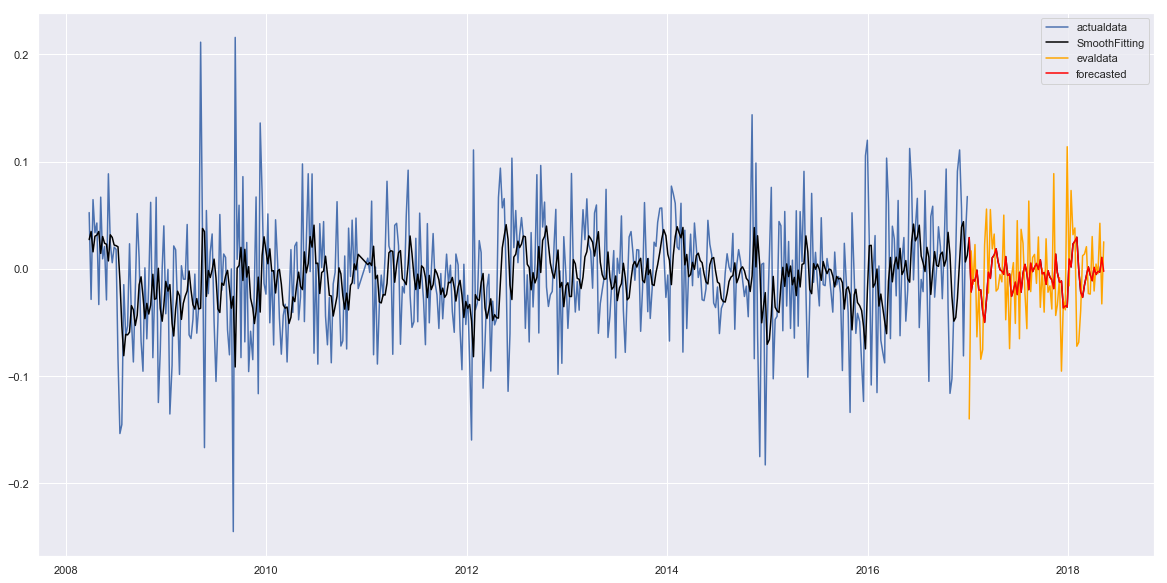

In [76]:
plt.figure(figsize=(20, 10))
        
plt.plot(simple_es.train.index, simple_es.train['7'],color='b', label='actualdata')
plt.plot(ndf['pub_date'].iloc[:-1], simple_es.fittedvalues,color='black', label='SmoothFitting')
plt.plot(simple_es.test.index, simple_es.test['7'],color='orange', label='evaldata')
plt.plot(simple_es.test.index, simple_es.predictions, color='red',label='forecasted')

plt.legend()
plt.savefig('simpleExponentialSmoothing_2.png')
plt.show()

### Inference ###

The above is the model which trained on **Smooth Trend(not the original trend though)** with one step forward prediction. Comparing forecasted value with smooth fitting makes sense. But, comparing the forecasted value with original trend it does not make much sense. 

May be we can keep this Simple Exponential Smoothing algorithm predictions as a BENCHMARK model and check models that perform better than this Algorithm


### Model Evaluation ###

Model Error Benchmark = 0.003407250707634592

    1. **CONV-1D** - 0.0029287541
    2. **Exponential Smoothing** - 0.00292382

### ARIMA ###

In [185]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

class GridSearch():
    def __init__(self, dataframe, p, d, q, forecasting_col, traindata, evaldata):
        self.dataset = dataframe
        self.pvalues = p
        self.dvalues = d
        self.qvalues = q
        self.traindata = traindata
        self.testdata = evaldata
        self.predictions = None
        self.bestParams = None
        self.forecastingcol = forecasting_col
        self.error = None
    
    def grid_search(self):
        best_score, best_cfg = float("inf"), None
        for p in self.pvalues:
            for d in self.dvalues:
                for q in self.qvalues:
                    order=(p,d,q)
                    """
                    mse, predictions = self.evaluate_arima_model(order)                   
                    if mse < best_score:
                            best_score, best_cfg = mse, order
                            self.predictions = predictions
                    """
                    
                    try:
                        mse, predictions = self.evaluate_arima_model(order)
                        if mse < best_score:
                            best_score, best_cfg = mse, order
                            self.predictions = predictions
                            print("Best Parameter Found... Error Rate:{}, Order:{}".format(mse, order))
                    except:
                        #print("exception occured......, orders:{},{},{}".format(p, d, q))
                        continue
                    
            
            print("\n Complete Iteration for P value:{} is completed \n".format(p))
        
        self.bestParams = best_cfg
        self.error = best_score
    
    def evaluate_arima_model(self, order):
        history = [x for x in self.traindata[[self.forecastingcol]].values.tolist()]
        test = self.testdata[[self.forecastingcol]].values.tolist()
        predictions = []
        
        pointer = 0
        
        for i in range(self.testdata.shape[0]):
            model = ARIMA(history, order=order)
            model_fit = model.fit(disp=False)
            
            preds, upper_conf, lower_conf = model_fit.forecast(steps=1)
            #append to the history
            history.append(preds)
            predictions.append(preds[0])
        
        #calculate out of sample error
        predictions = [x for x in predictions]
        error = mean_squared_error(self.testdata[[self.forecastingcol]].values.tolist(), predictions)
        
        return error, predictions

In [186]:
#parameters
p_values = [x for x in range(0, 10)]
d_values = range(0, 3)
q_values = range(0, 3)

In [ ]:
arima_model = GridSearch(ndf, p_values, d_values, q_values, '7', ndf_trainsplit, ndf_evalsplit)
arima_model.grid_search() #run the grid search function

Best Parameter Found... Error Rate:0.0028215546492835492, Order:(0, 0, 0)
Best Parameter Found... Error Rate:0.002821367882434789, Order:(0, 0, 1)
Best Parameter Found... Error Rate:0.0028204350885421905, Order:(0, 0, 2)


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best Parameter Found... Error Rate:0.002779739718399647, Order:(0, 1, 1)


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/pytho


 Complete Iteration for P value:0 is completed 



/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/loca


 Complete Iteration for P value:1 is completed 



/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  


 Complete Iteration for P value:2 is completed 



/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: over


 Complete Iteration for P value:3 is completed 



/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: over


 Complete Iteration for P value:4 is completed 



/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: over


 Complete Iteration for P value:5 is completed 



/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/site-packages/statsmodels


 Complete Iteration for P value:6 is completed 



In [37]:
print("Best Params:\n")
print("Order Param:{}".format(arima_model.bestParams))
print("MSE:{}".format(arima_model.error))

Best Params:

Order Param:(2, 1, 1)
MSE:0.0027786129079837


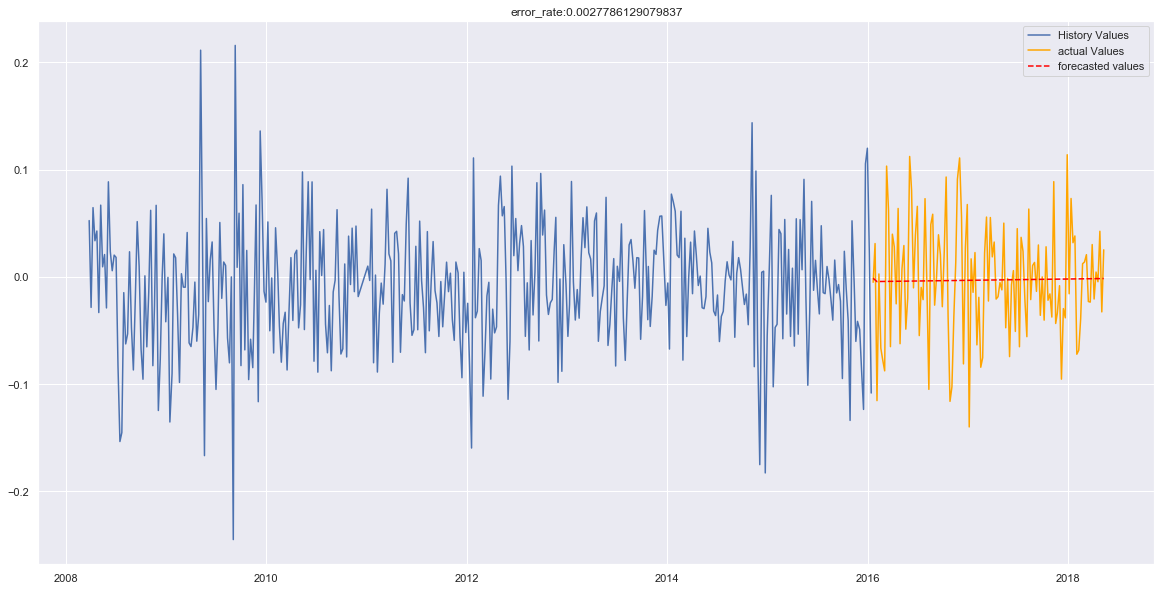

In [39]:
plot_trend(arima_model.traindata, arima_model.testdata.index,
           arima_model.testdata['7'], arima_model.predictions,arima_model.error,
           'arima_performance_2.png')

### inference ###

ARIMA model uses past data to understand the pattern in the time series. Since there is no particular trend in the data the model failed to capture the Trend.

The residuals error for each year differs drastically thus model errors will be carried forward also

### Neural Nets  ###

Try - Conv1D, LSTM Network

### Traditional ML models ###

Try
LinearRegression(won't give optimal performance though),
K-Nearest Neighbors(will try)
XGBoost Regressor
RandomForest Regressor with defined inputs

In [70]:
##checking the correlation
ndf.corr()

,Unnamed: 0,Unnamed: 0.1,actual,forecast,previous,rolling_std,z-score,1,5,6,7,year
Unnamed: 0,1.000000,1.000000,-0.101842,-0.100290,-0.099953,0.091962,-0.061790,-0.666186,-0.666725,0.469649,0.063737,0.995206
Unnamed: 0.1,1.000000,1.000000,-0.101842,-0.100290,-0.099953,0.091962,-0.061790,-0.666186,-0.666725,0.469649,0.063737,0.995206
actual,-0.101842,-0.101842,1.000000,0.993708,0.886568,-0.563201,0.177341,0.132553,0.132875,-0.298555,-0.023186,-0.140498
forecast,-0.100290,-0.100290,0.993708,1.000000,0.905591,-0.576162,0.092373,0.127097,0.128232,-0.300970,0.008814,-0.140198
previous,-0.099953,-0.099953,0.886568,0.905591,1.000000,-0.599557,0.011526,0.126162,0.126914,-0.268180,0.045794,-0.146195
rolling_std,0.091962,0.091962,-0.563201,-0.576162,-0.599557,1.000000,-0.017253,-0.051322,-0.050830,0.206108,0.030338,0.148208
z-score,-0.061790,-0.061790,0.177341,0.092373,0.011526,-0.017253,1.000000,0.074040,0.066411,-0.024731,-0.215708,-0.060566
1,-0.666186,-0.666186,0.132553,0.127097,0.126162,-0.051322,0.074040,1.000000,0.999352,-0.345415,-0.034273,-0.665267
5,-0.666725,-0.666725,0.132875,0.128232,0.126914,-0.050830,0.066411,0.999352,1.000000,-0.345757,-0.024428,-0.665775
6,0.469649,0.469649,-0.298555,-0.300970,-0.268180,0.206108,-0.024731,-0.345415,-0.345757,1.000000,0.110570,0.474406


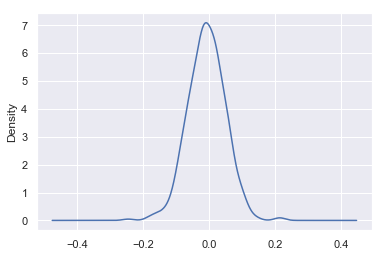

In [157]:
##apply logirathmic in the data and see how the standard statistical model 
##is performing
ndf['7'].plot.kde()

### Model Performance ###

    Linear Regression - 0.0032588196660954753
    Polynomial Regression - 0.0033302277906029965
    KNN - 0.0034130883262833865
    Random Forest - 0.003288814866207051
    XGBoost - 0.003501060691858552

In [51]:
##sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def split_dataset_for_ml(maindf, input_cols, target):
    #if we are treating this as a traditional regression
    #problem, then we do not have to worry about the time parameter.
    #as we are gonna predict the target variable with independent features
    X_train, X_test, y_train, y_test = train_test_split(
                    maindf[input_cols], maindf[target], test_size=0.33, random_state=7)
    
    #take logarithmic and see what is the model performance
    
    
    return X_train, y_train, X_test, y_test

def calculate_error_rate(y, y0):
    score = mean_squared_error(y, y0)
    return score

def model_preds(model, testdata):
    preds = model.predict(testdata)
    return preds

def model_plot(y, y0):
    act = y.values.tolist()
    plt.figure(figsize=(20, 10))
    plt.plot(act, color='orange', label='actual values')
    plt.plot(y0, color='red', label='predicted values')
    
    plt.legend()
    plt.show()

In [79]:
input_cols = ['actual', 'forecast', 'rolling_std', 'z-score', '1']
target = '7'

X_train, y_train, X_test, y_test = split_dataset_for_ml(ndf, input_cols, target)
print("Train Data Shape:{}, {}".format(X_train.shape, y_train.shape))
print("Test Data Shape:{}, {}".format(X_test.shape, y_test.shape))

Train Data Shape:(351, 5), (351,)
Test Data Shape:(174, 5), (174,)


Error Rate of Linear Regression:0.0032588196660954753


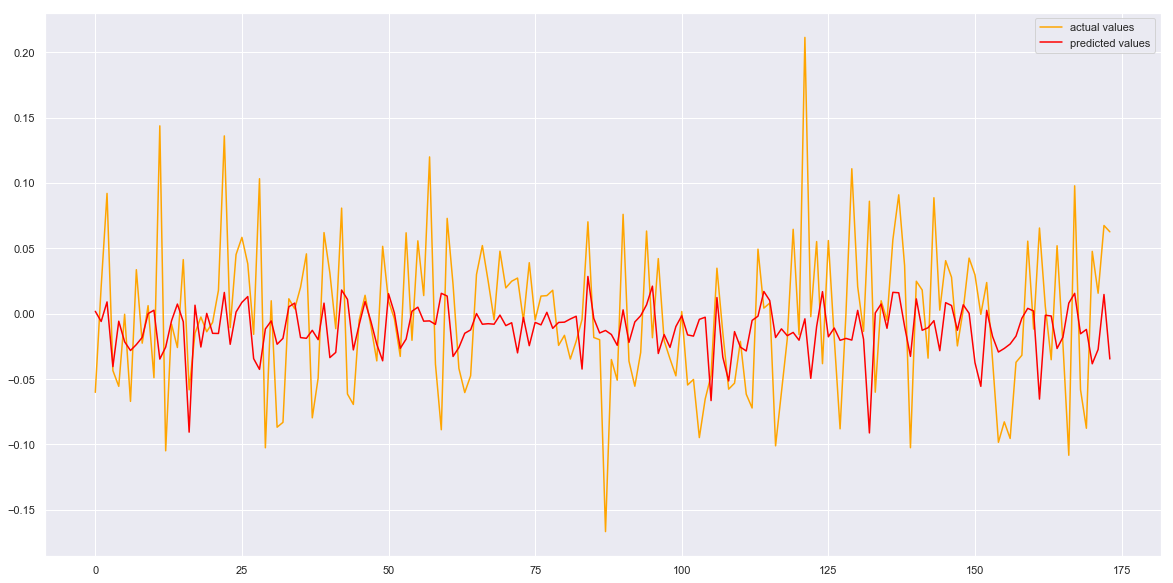

In [80]:
#linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

preds = model_preds(linear_model, X_test)
print("Error Rate of Linear Regression:{}".format(calculate_error_rate(y_test, preds)))

model_plot(y_test, preds)

Error Rate of Polynomial Regression:0.0033302277906029965


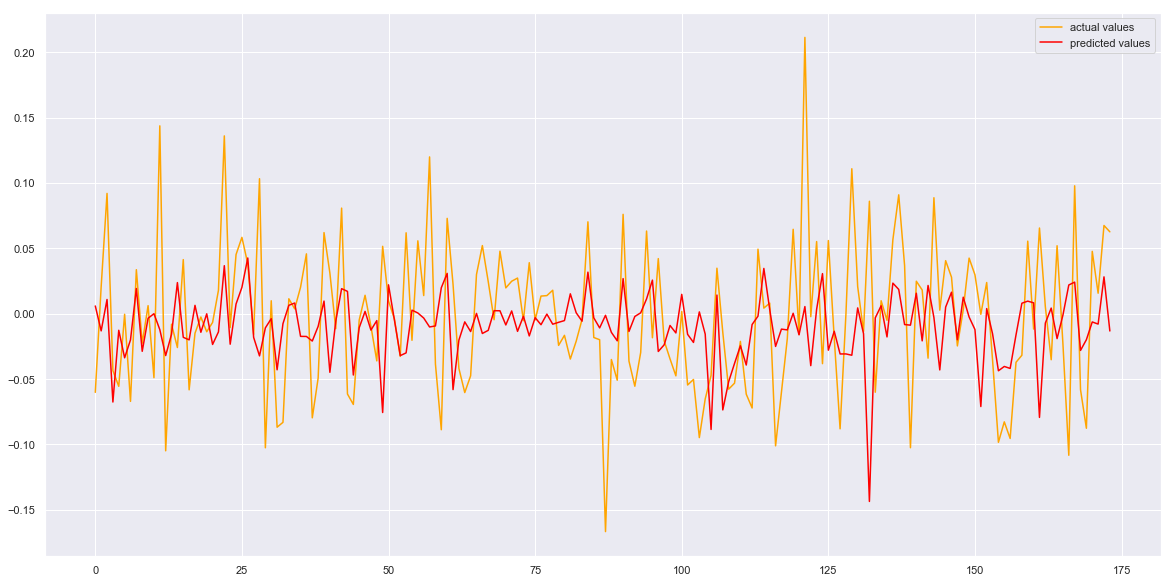

In [148]:
#ploynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

poly.fit(X_poly, y_train)

lin2 = LinearRegression()
lin2.fit(X_poly, y_train)


#polynomial transformation for Test Data
Xtest_poly = poly.fit_transform(X_test)

poly_preds = lin2.predict(Xtest_poly)
print("Error Rate of Polynomial Regression:{}".format(calculate_error_rate(y_test, poly_preds)))

model_plot(y_test, poly_preds)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Error Rate of KNN:0.0034130883262833865


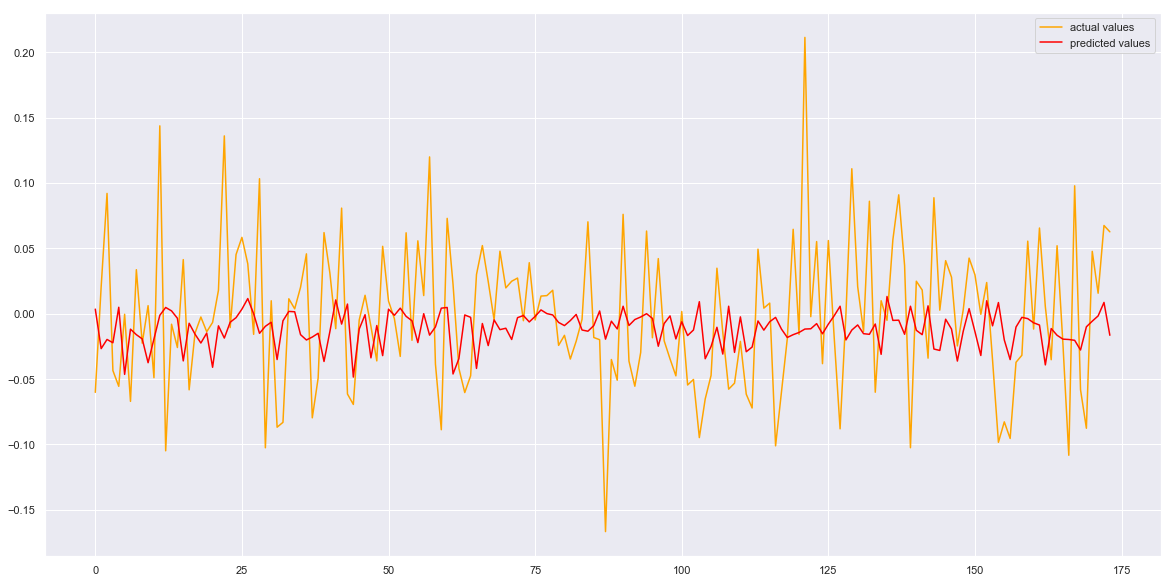

In [147]:
#knn algorithm
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors':[x for x in range(2, 20)]}
knn = neighbors.KNeighborsRegressor()

knn_model = GridSearchCV(knn,  params, cv=5)

knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

print("Error Rate of KNN:{}".format(calculate_error_rate(y_test, knn_preds)))
model_plot(y_test, knn_preds)

Feature Importance:[0.13400289 0.13186942 0.20677927 0.32090834 0.20644008]
Error Rate of Linear Regression:0.003288814866207051


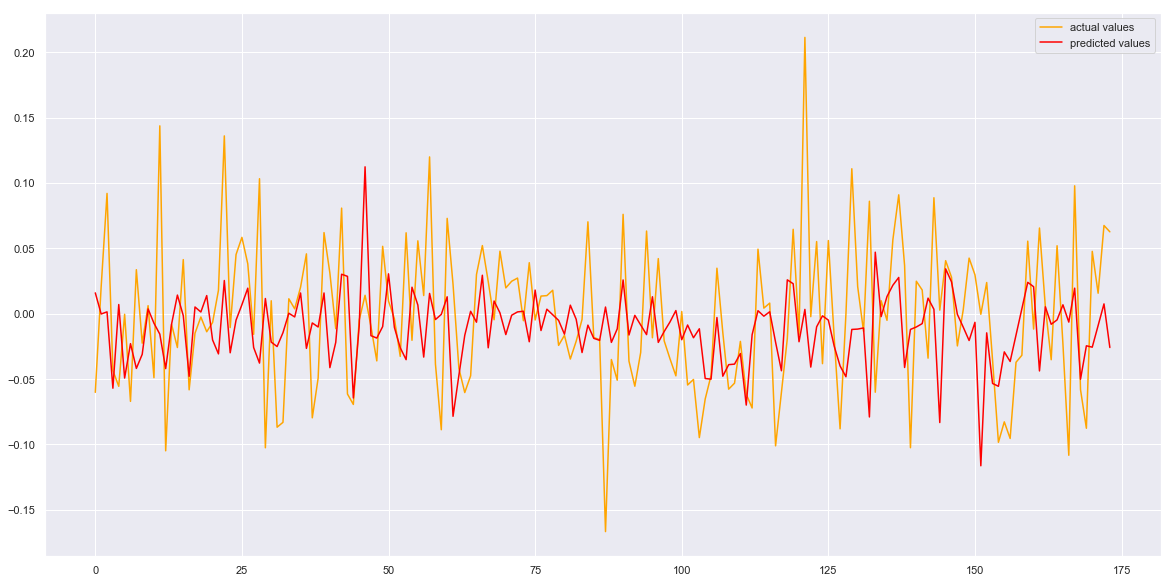

In [116]:
#RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=150, random_state=10)
regressor.fit(X_train, y_train)

#print important features
print("Feature Importance:{}".format(regressor.feature_importances_))

regressor_preds = regressor.predict(X_test)
print("Error Rate of RandomForest Regression:{}".format(calculate_error_rate(y_test, regressor_preds)))
model_plot(y_test, regressor_preds)

In [123]:
#xgboost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

def perform_cv(model, params, train_data, train_labels, test_data, test_labels):
    
        #print(train_data.shape, train_labels.shape)
    
        cv = RandomizedSearchCV(model, cv=3, verbose=2,
                scoring='r2',
                param_distributions=params, n_jobs=1)

        cv.fit(train_data, train_labels)

        print("Best CV Error:{}".format(cv.best_score_))
        print("Best Estimator:{}".format(cv.best_estimator_))
        print("Test Error:{}".format(cv.score(test_data, test_labels)))

        train_predict = cv.predict(train_data)
        test_predict = cv.predict(test_data)

        print("\n TRAIN SCORES \n")
        print("MSE:{}".format(mean_squared_error(train_labels, train_predict)))
        
        print("\n TEST SCORES \n") 
        print("MSE:{}".format(mean_squared_error(test_labels, test_predict)))

        return cv

#xgboost parameters
xgb_params = {'n_estimators':[20,30,50,100,200,300,500,1000], 'max_depth':range(3, 20, 2),
            'learning_rate':[0.001, 0.1, 0.0001, 1.0]}

bagging_regressor = xgb.XGBRegressor(objective='reg:linear')

#cross validation
cv_xgb = perform_cv(bagging_regressor, xgb_params, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, max_depth=13, learning_rate=0.1 ...............
[CV]  n_estimators=200, max_depth=13, learning_rate=0.1, total=   0.1s
[CV] n_estimators=200, max_depth=13, learning_rate=0.1 ...............
[CV]  n_estimators=200, max_depth=13, learning_rate=0.1, total=   0.1s
[CV] n_estimators=200, max_depth=13, learning_rate=0.1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=200, max_depth=13, learning_rate=0.1, total=   0.1s
[CV] n_estimators=500, max_depth=5, learning_rate=0.1 ................
[CV] . n_estimators=500, max_depth=5, learning_rate=0.1, total=   0.2s
[CV] n_estimators=500, max_depth=5, learning_rate=0.1 ................


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . n_estimators=500, max_depth=5, learning_rate=0.1, total=   0.1s
[CV] n_estimators=500, max_depth=5, learning_rate=0.1 ................
[CV] . n_estimators=500, max_depth=5, learning_rate=0.1, total=   0.1s
[CV] n_estimators=20, max_depth=19, learning_rate=0.1 ................
[CV] . n_estimators=20, max_depth=19, learning_rate=0.1, total=   0.0s
[CV] n_estimators=20, max_depth=19, learning_rate=0.1 ................
[CV] . n_estimators=20, max_depth=19, learning_rate=0.1, total=   0.0s
[CV] n_estimators=20, max_depth=19, learning_rate=0.1 ................
[CV] . n_estimators=20, max_depth=19, learning_rate=0.1, total=   0.0s
[CV] n_estimators=500, max_depth=17, learning_rate=0.001 .............


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=500, max_depth=17, learning_rate=0.001, total=   0.1s
[CV] n_estimators=500, max_depth=17, learning_rate=0.001 .............
[CV]  n_estimators=500, max_depth=17, learning_rate=0.001, total=   0.1s
[CV] n_estimators=500, max_depth=17, learning_rate=0.001 .............
[CV]  n_estimators=500, max_depth=17, learning_rate=0.001, total=   0.1s
[CV] n_estimators=300, max_depth=13, learning_rate=0.1 ...............


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=300, max_depth=13, learning_rate=0.1, total=   0.1s
[CV] n_estimators=300, max_depth=13, learning_rate=0.1 ...............
[CV]  n_estimators=300, max_depth=13, learning_rate=0.1, total=   0.2s
[CV] n_estimators=300, max_depth=13, learning_rate=0.1 ...............


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=300, max_depth=13, learning_rate=0.1, total=   0.2s
[CV] n_estimators=30, max_depth=15, learning_rate=0.001 ..............
[CV]  n_estimators=30, max_depth=15, learning_rate=0.001, total=   0.0s
[CV] n_estimators=30, max_depth=15, learning_rate=0.001 ..............
[CV]  n_estimators=30, max_depth=15, learning_rate=0.001, total=   0.0s
[CV] n_estimators=30, max_depth=15, learning_rate=0.001 ..............
[CV]  n_estimators=30, max_depth=15, learning_rate=0.001, total=   0.0s
[CV] n_estimators=50, max_depth=17, learning_rate=1.0 ................
[CV] . n_estimators=50, max_depth=17, learning_rate=1.0, total=   0.0s
[CV] n_estimators=50, max_depth=17, learning_rate=1.0 ................
[CV] . n_estimators=50, max_depth=17, learning_rate=1.0, total=   0.0s
[CV] n_estimators=50, max_depth=17, learning_rate=1.0 ................
[CV] . n_estimators=50, max_depth=17, learning_rate=1.0, total=   0.0s
[CV] n_estimators=100, max_depth=3, learning_rate=0.0001 .............
[CV

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/x

[CV] n_estimators=100, max_depth=3, learning_rate=0.0001 .............
[CV]  n_estimators=100, max_depth=3, learning_rate=0.0001, total=   0.0s
[CV] n_estimators=100, max_depth=3, learning_rate=0.0001 .............
[CV]  n_estimators=100, max_depth=3, learning_rate=0.0001, total=   0.0s
[CV] n_estimators=200, max_depth=5, learning_rate=0.1 ................
[CV] . n_estimators=200, max_depth=5, learning_rate=0.1, total=   0.1s
[CV] n_estimators=200, max_depth=5, learning_rate=0.1 ................


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . n_estimators=200, max_depth=5, learning_rate=0.1, total=   0.1s
[CV] n_estimators=200, max_depth=5, learning_rate=0.1 ................
[CV] . n_estimators=200, max_depth=5, learning_rate=0.1, total=   0.1s
[CV] n_estimators=1000, max_depth=3, learning_rate=0.0001 ............


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=1000, max_depth=3, learning_rate=0.0001, total=   0.2s
[CV] n_estimators=1000, max_depth=3, learning_rate=0.0001 ............
[CV]  n_estimators=1000, max_depth=3, learning_rate=0.0001, total=   0.2s
[CV] n_estimators=1000, max_depth=3, learning_rate=0.0001 ............


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  n_estimators=1000, max_depth=3, learning_rate=0.0001, total=   0.2s
Best CV Error:-0.10014703579455346
Best Estimator:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Test Error:-0.11615043788940893

 TRAIN SCORES 

MSE:5.2367155146194023e-05

 TEST SCORES 

MSE:0.003501060691858552


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.5s finished
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Error Rate of XGBRegressor:0.003501060691858552


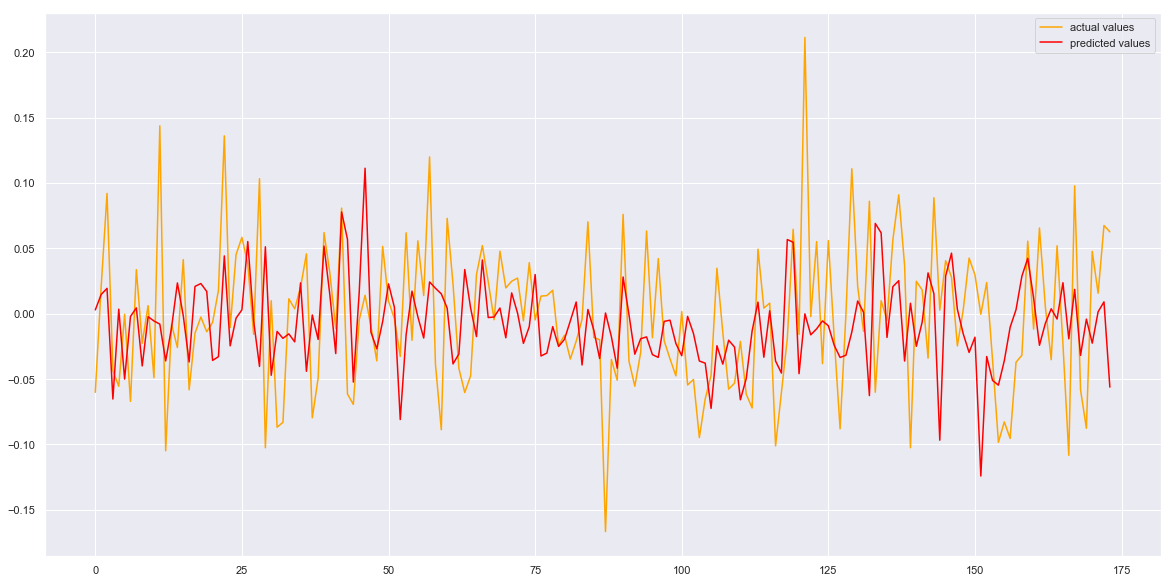

In [146]:
#training with best parameter
bestEstimator = cv_xgb.best_estimator_
bestEstimator.fit(X_train, y_train)

xgb_preds = bestEstimator.predict(X_test)
print("Error Rate of XGBRegressor:{}".format(calculate_error_rate(y_test, xgb_preds)))
model_plot(y_test, xgb_preds)

In [139]:
print(ndf['7'].min(), ndf['7'].max())
print(odf['7'].min(), odf['7'].max())

-0.2448811458401785 0.2157913997798264
-0.16367178838664165 0.11387687821889615


In [125]:
##all the above traditional models, even neural nets are failing to capture
##the spikes that are happening in the data. 